Zachary Armand

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import Adam
from torch.nn import functional as F
from torch.utils.data import random_split
from torch.utils.data import DataLoader, Dataset, TensorDataset
from torch.nn import Linear, ReLU, Sequential
from torch.optim.lr_scheduler import CosineAnnealingLR


# Local import
from RNN_Model.tools import train_model, evaluate_model, calculate_R2_score, get_predictions
from EarlyStopping import EarlyStopping

In [99]:
DEVICE = torch.device("mps" if torch.backends.mps.is_available() else ("cuda" if torch.cuda.is_available() else "cpu"))
print("Using:", DEVICE)

Using: cuda


In [100]:
#pip freeze > requirements.txt

# Load Data and Create Dataset

In [101]:
input_values = torch.load('./datasets/input_values.pth')
target_values = torch.load('./datasets/target_values.pth')

Dataset and dataloaders are used for both models.

In [102]:
# Create Dataset
dataset = TensorDataset(input_values, target_values)

# Split into test and train data
train_dataset, test_dataset = random_split(dataset, [0.9, 0.1])
train_dataset, valid_dataset = random_split(train_dataset, [0.89, 0.11])
print(f"Train: {len(train_dataset)/len(dataset)*100:.1f}%, Test: {len(test_dataset)/len(dataset)*100:.1f}%, Valid: {len(valid_dataset)/len(dataset)*100:.1f}%")
print(f"Train: {len(train_dataset)}, Test: {len(test_dataset)}, Valid: {len(valid_dataset)}")

# Create consistent test dataloader
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=True)

Train: 80.1%, Test: 10.0%, Valid: 9.9%
Train: 57640, Test: 7195, Valid: 7123


### Scale Dataset

In [103]:
# Convert datasets to tensors for easier manipulation
train_inputs = torch.stack([x[0] for x in train_dataset])
valid_inputs = torch.stack([x[0] for x in valid_dataset])
test_inputs = torch.stack([x[0] for x in test_dataset])

# Check the shape of the inputs to ensure it's 4D (e.g., (num_samples, channels, height, width))
print(f"Train inputs shape: {train_inputs.shape}")
print(f"Valid inputs shape: {valid_inputs.shape}")
print(f"Test inputs shape: {test_inputs.shape}")

# Store the original shape for later reshaping
original_shape = train_inputs.shape[1:]  # (channels, height, width) or whatever your original shape was

# Reshape the inputs to 2D (samples, features) for scaling
train_inputs_reshaped = train_inputs.view(train_inputs.size(0), -1)
valid_inputs_reshaped = valid_inputs.view(valid_inputs.size(0), -1)
test_inputs_reshaped = test_inputs.view(test_inputs.size(0), -1)

# Scale the inputs using StandardScaler (you could also use MinMaxScaler or another scaler)
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

# Fit scaler on training data and transform
train_inputs_scaled = torch.tensor(scaler.fit_transform(train_inputs_reshaped.numpy()), dtype=torch.float32)

# Use the same scaler to transform the validation and test data
valid_inputs_scaled = torch.tensor(scaler.transform(valid_inputs_reshaped.numpy()), dtype=torch.float32)
test_inputs_scaled = torch.tensor(scaler.transform(test_inputs_reshaped.numpy()), dtype=torch.float32)

# Reshape the scaled inputs back to the original shape (samples, channels, height, width)
train_inputs_scaled = train_inputs_scaled.view(train_inputs.size(0), *original_shape)
valid_inputs_scaled = valid_inputs_scaled.view(valid_inputs.size(0), *original_shape)
test_inputs_scaled = test_inputs_scaled.view(test_inputs.size(0), *original_shape)

# Recreate the datasets with the scaled inputs
train_dataset = TensorDataset(train_inputs_scaled, torch.stack([x[1] for x in train_dataset]))
valid_dataset = TensorDataset(valid_inputs_scaled, torch.stack([x[1] for x in valid_dataset]))
test_dataset = TensorDataset(test_inputs_scaled, torch.stack([x[1] for x in test_dataset]))

# Create consistent test dataloader
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=True)

Train inputs shape: torch.Size([57640, 9, 15])
Valid inputs shape: torch.Size([7123, 9, 15])
Test inputs shape: torch.Size([7195, 9, 15])


# Linear model

After hyperparameter tuning, the linear network hyperparameters are:
- Batch size: 64
- Learning rate: 0.001
- Dropout: 0.0
- L2 weight decay: 0.0

In [218]:
class SimpleNet(nn.Module):
    def __init__(self, in_features=12, seq_len=8, hidden_features=32, dropout=0.0):
        super().__init__()
        
        self.input_layer = nn.Linear(in_features*seq_len, hidden_features)
        self.middle_layer = nn.Linear(hidden_features, hidden_features)
        self.output_layer = nn.Linear(hidden_features, 1)

        self.dropout = nn.Dropout(dropout)
        self.relu = nn.LeakyReLU(0.01)

    def forward(self, x):
        x = torch.flatten(x, 1)
        # Input layer
        x = self.input_layer(x)
        x = self.relu(x)
        # Middle layer with residual
        x = self.middle_layer(x)
        x = self.relu(x)
        x = self.dropout(x)
        # Final output layer
        x = self.relu(self.output_layer(x))
        return x.squeeze()  # Remove extra dimension for regression tasks

In [367]:
batch_size = 128
num_epochs = 150
early_stop_patience = 15

# Turn dataset into Dataloaders
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=True)

# Create model object
in_features, seq_len = train_dataloader.dataset[0][0].shape
simple_baseball_mlp = SimpleNet(in_features=in_features, seq_len=seq_len, hidden_features=16, dropout=0.0).to(DEVICE)

# Print trainable parameters
trainable_params = sum(p.numel() for p in simple_baseball_mlp.parameters() if p.requires_grad)
print(f"Trainable parameters: {trainable_params:,}")

# Optimizer and scheduler
optimizer = optim.AdamW(simple_baseball_mlp.parameters(), lr=0.0001, weight_decay=0.01)
#scheduler = CosineAnnealingLR(optimizer, T_max=50)
early_stopper = EarlyStopping(patience=early_stop_patience, min_delta=0.0001)

# Training logs
mlp_log = []
mlp_eval_log = []
mlp_grads = []

# Loop
pbar = tqdm(range(num_epochs), desc="Training MLP")
for epoch in pbar:
    # Get average loss over batches for training
    avg_train_loss = train_model(simple_baseball_mlp, optimizer, train_dataloader, DEVICE, loss_fn='MSE', grad_clip=None)
    mlp_log.append(avg_train_loss)

    # Validation loss
    avg_valid_loss = evaluate_model(model=simple_baseball_mlp, data_loader=valid_dataloader, device=DEVICE, loss_fn='MSE')
    mlp_eval_log.append(avg_valid_loss)


    grads = {n:p.grad.cpu() for n, p in simple_baseball_mlp.named_parameters()}
    mlp_grads.append(grads)

    # Step scheduler
    #current_lr = scheduler.get_last_lr()
    #scheduler.step()

    # Early Stopping
    early_stopper(avg_valid_loss)
    if early_stopper.early_stop:
        print(f"Early stopping at epoch {epoch}")
        break

    # Update progress bar
    #'LR': current_lr[0],
    pbar.set_postfix({'Train loss': avg_train_loss, 'Validation loss': avg_valid_loss, 'ES Counter': early_stopper.counter})

Trainable parameters: 2,465


Training MLP:  45%|████▍     | 67/150 [01:02<01:17,  1.08it/s, Train loss=0.128, Validation loss=0.132, ES Counter=15]

Early stopping at epoch 67


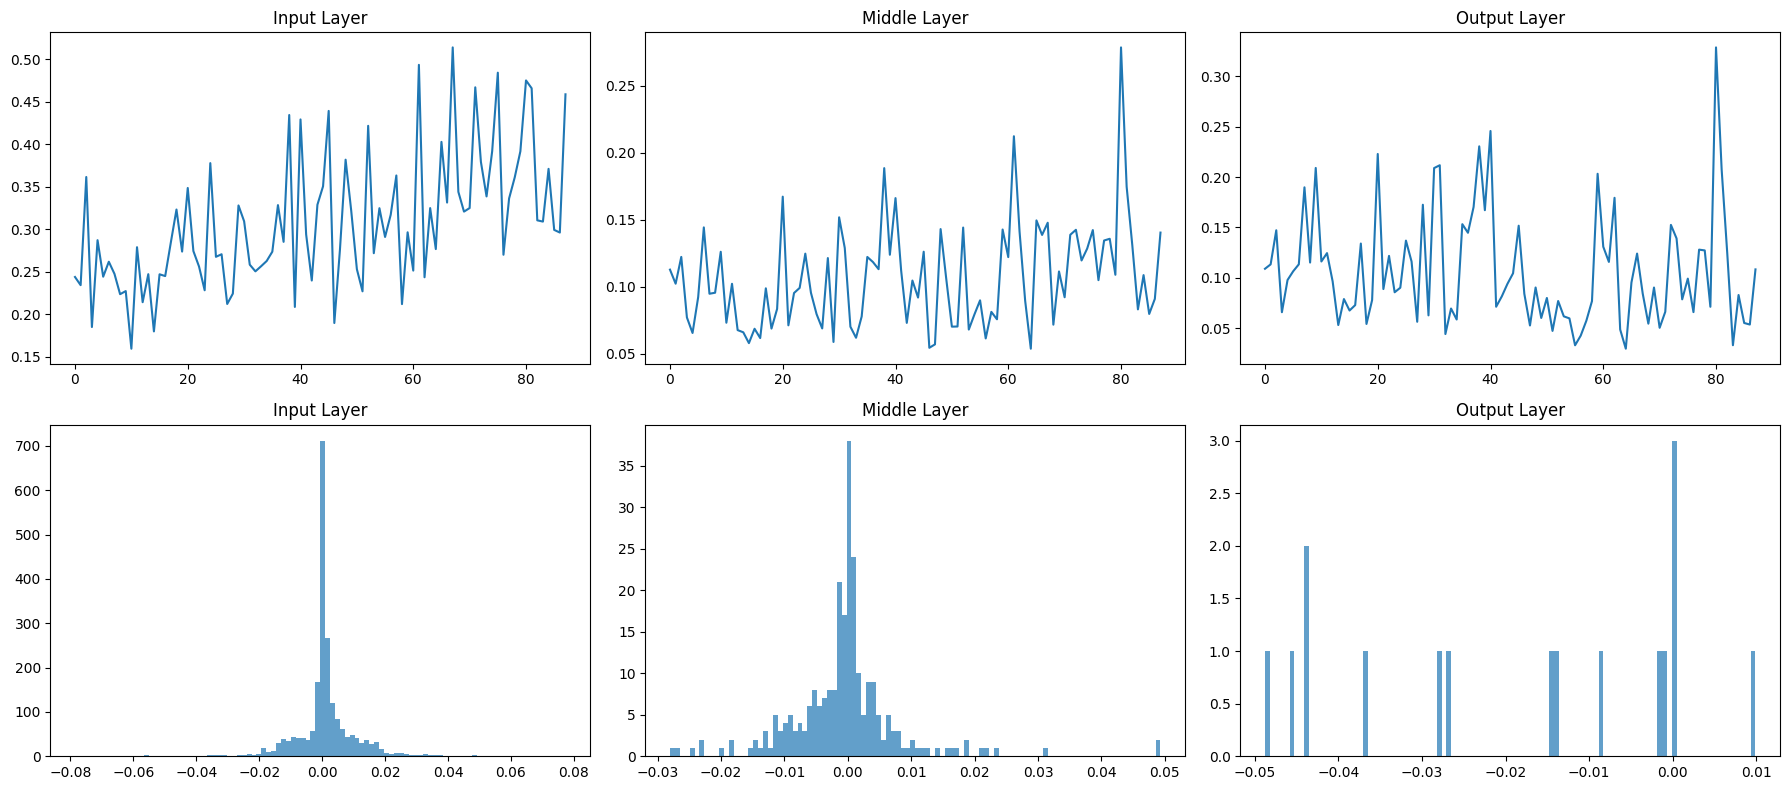

In [360]:
input_layer_grad_norm = [torch.norm(mlp_grads[i]['input_layer.weight']).item() for i in range(len(mlp_grads))]
middle_layer_grad_norm = [torch.norm(mlp_grads[i]['middle_layer.weight']).item() for i in range(len(mlp_grads))]
output_layer_grad_norm = [torch.norm(mlp_grads[i]['output_layer.weight']).item() for i in range(len(mlp_grads))]

# Create a figure and subplots (2 row, 3 columns)
fig, axs = plt.subplots(2, 3, figsize=(18, 8))
axs[0, 0].plot(input_layer_grad_norm)
axs[0, 0].set_title('Input Layer')
axs[0, 1].plot(middle_layer_grad_norm)
axs[0, 1].set_title('Middle Layer')
axs[0, 2].plot(output_layer_grad_norm)
axs[0, 2].set_title('Output Layer')
i = epoch
axs[1, 0].hist(mlp_grads[i]['input_layer.weight'].flatten().cpu().numpy(), bins=100, alpha=0.7)
axs[1, 0].set_title('Input Layer')
axs[1, 1].hist(mlp_grads[i]['middle_layer.weight'].flatten().cpu().numpy(), bins=100, alpha=0.7)
axs[1, 1].set_title('Middle Layer')
axs[1, 2].hist(mlp_grads[i]['output_layer.weight'].flatten().cpu().numpy(), bins=100, alpha=0.7)
axs[1, 2].set_title('Output Layer')

plt.tight_layout()
plt.show()

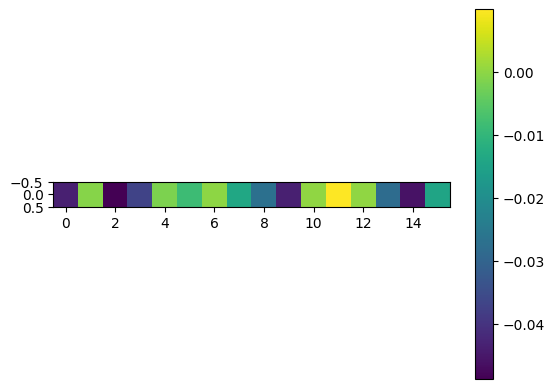

In [363]:
grads = {n:p.grad.cpu() for n, p in simple_baseball_mlp.named_parameters()}
plt.imshow(grads['output_layer.weight'])
plt.colorbar()
plt.show()

In [364]:
# Evaluate model - 
mlp_test_RMSE = evaluate_model(model=simple_baseball_mlp, data_loader=test_dataloader, device=DEVICE, loss_fn='RMSE')
mlp_test_MSE = evaluate_model(model=simple_baseball_mlp, data_loader=test_dataloader, device=DEVICE, loss_fn='MSE')
mlp_test_MAE = evaluate_model(model=simple_baseball_mlp, data_loader=test_dataloader, device=DEVICE, loss_fn='MAE')

# Get predictions
mlp_targets, mlp_predictions = get_predictions(simple_baseball_mlp, test_dataloader, DEVICE)
mlp_test_r2 = calculate_R2_score(mlp_targets, mlp_predictions)

print(f'Test RMSE: {mlp_test_RMSE:.4f}, Test MSE: {mlp_test_MSE:.4f}, Test MAE: {mlp_test_MAE:.4f}, Test R2: {mlp_test_r2:.2f}')

Test RMSE: 0.3551, Test MSE: 0.1301, Test MAE: 0.2751, Test R2: 0.10


In [332]:
i = np.random.randint(0, high=5000, size=1, dtype='int').item()
mlp_predictions[i]

np.float32(0.34417057)

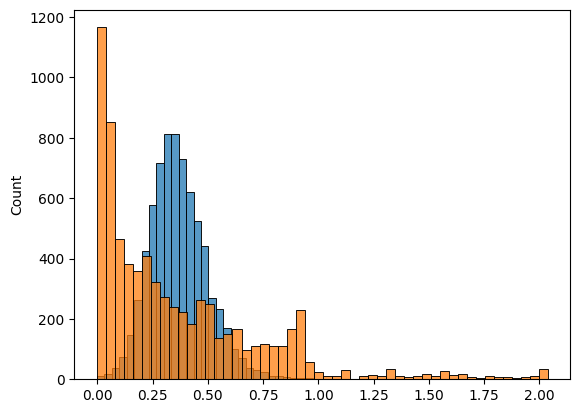

In [365]:
n_bins = 50
sns.histplot(mlp_predictions, bins=50)
sns.histplot(mlp_targets, bins=n_bins)
plt.show()

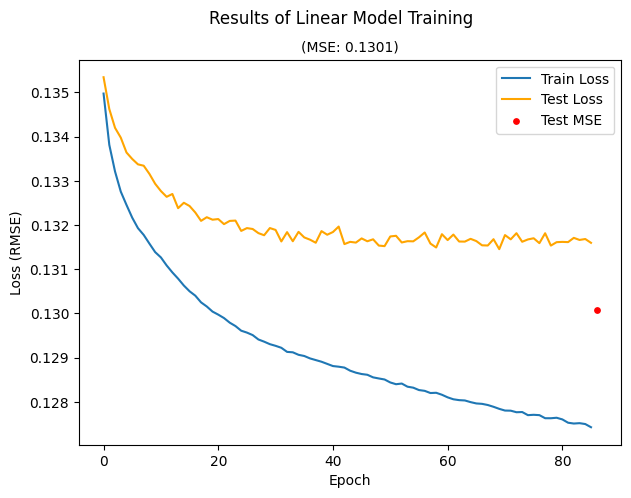

In [366]:
# Plot loss over time, final test stats
plt.figure(figsize=(7, 5))
plt.suptitle("Results of Linear Model Training")
plt.title(f"(MSE: {mlp_test_MSE:.4})", size=10)
plt.ylabel('Loss (RMSE)')
plt.xlabel('Epoch')
plt.plot(mlp_log[2:], label='Train Loss')
plt.plot(mlp_eval_log[2:], label='Test Loss', color='orange')
plt.scatter(x=epoch-1, y=mlp_test_MSE, color='r', label="Test MSE", s=15)
plt.legend()
plt.show()

In [111]:
'''grads = {n:p.grad.cpu() for n, p in simple_baseball_mlp.named_parameters()}
plt.imshow(grads['mlpnet.9.weight'])
plt.colorbar()
plt.show()'''

"grads = {n:p.grad.cpu() for n, p in simple_baseball_mlp.named_parameters()}\nplt.imshow(grads['mlpnet.9.weight'])\nplt.colorbar()\nplt.show()"

In [349]:
torch.tensor(mlp_predictions).cpu().numpy()

array([0.32311904, 0.194945  , 0.45343786, ..., 0.4172465 , 0.10216688,
       0.5327909 ], dtype=float32)

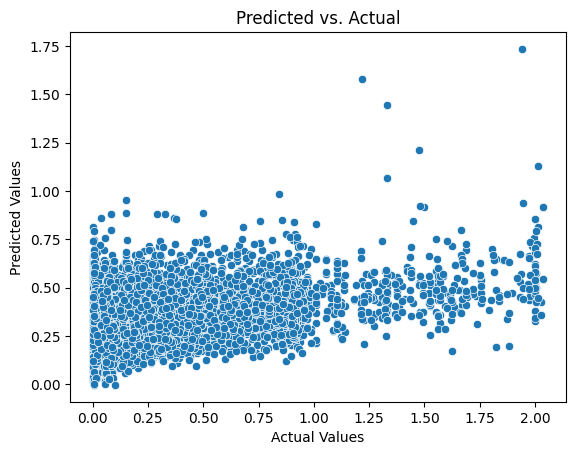

In [357]:
# Plot predicted vs. actual
plt.title("Predicted vs. Actual")
plt.ylabel("Predicted Values")
plt.xlabel("Actual Values")
sns.scatterplot(x=mlp_targets, y=mlp_predictions)
plt.show()

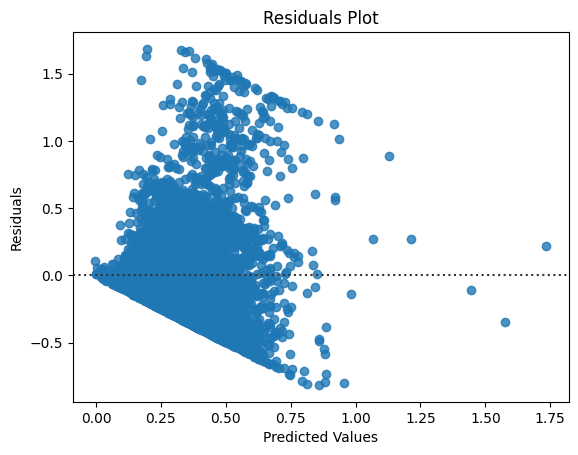

In [358]:
# Plot residuals
plt.title("Residuals Plot")
plt.ylabel("Residuals")
plt.xlabel("Predicted Values")
sns.residplot(x=mlp_predictions, y=mlp_targets, line_kws={"color": "red"})
plt.show()

# RNN model

After hyperparameter tuning, the RNN hyperparameters are:
- Batch size: 32
- GRU layers: 2
- Learning rate: 0.001
- Dropout: 0.5
- L2 weight decay: 0.0001

In [ ]:
class BaseballRNN(torch.nn.Module):
    def __init__(self, input_size, output_size=1, hidden_size=256, n_layers=1, bidirectional=False, hidden_init='rand', rnn_dropout=0.2):
        super().__init__()

        self.hidden_size = hidden_size
        self.n_layers = n_layers
        self.hidden_init = hidden_init
        self.rnn_dropout = rnn_dropout

        # Input fc layer
        self.fc_in = nn.Linear(input_size, self.hidden_size)
        # GRU Layer
        self.rnn1 = nn.GRU(self.hidden_size, self.hidden_size, batch_first=True, num_layers=self.n_layers, dropout=self.rnn_dropout, bidirectional=False)
        # Dropout layer after last GRU layer
        self.layernorm = nn.LayerNorm(self.hidden_size)
        self.dropout = nn.Dropout(self.rnn_dropout)
        # Fully connected layer
        self.fc1 = nn.Linear(self.hidden_size, 32)  # fixed number of neurons in the linear layer
        # Output layer
        self.fc_out = nn.Linear(32, output_size) 
        
        # RELU
        self.relu = nn.ReLU()

    def _init_hidden(self, batch_size, device):
        """Initialize the hidden state for the GRU."""
        if self.hidden_init == 'zero':
            h0 = torch.zeros(self.n_layers, batch_size, self.hidden_size, device=device)
        elif self.hidden_init == 'rand':
            h0 = torch.randn(self.n_layers, batch_size, self.hidden_size, device=device)
        elif self.hidden_init == 'xavier':
            h0 = torch.zeros(self.n_layers, batch_size, self.hidden_size, device=device)
            nn.init.xavier_uniform_(h0)
        else:
            raise ValueError(f"Unsupported hidden_init: {self.hidden_init}")
        return h0

    def forward(self, x):      
        # Initial hidden states for RNNs
        h0 = self._init_hidden(x.size(0), x.device)
        
        # Pre RNN Linear Layer
        x = self.relu(self.fc_in(x))

        # Send through RNN 
        #residual = x
        out, hidden = self.rnn1(x, h0)
        #out = out + residual  # Residual connection
        # Get output of the last time step
        out = out[:, -1, :]  # (batch_size, seq_len, hidden_size)
        out = self.layernorm(out)
        out = self.dropout(out)

        # Send through fully connected layers
        out = self.relu(self.fc1(out))
        out = self.dropout(out) #+ out

        # Output layer
        out = self.fc_out(out)

        return out.squeeze()

In [243]:
batch_size = 256
num_epochs = 500
early_stop_patience = 15

# Turn dataset into Dataloaders
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=True)

# Create model object
input_size = train_dataloader.dataset[0][0].size()[1]
baseball_rnn = BaseballRNN(input_size=input_size, output_size=1, hidden_size=128,
                                n_layers=5, hidden_init='rand', rnn_dropout=0.33).to(DEVICE)

# Print trainable parameters
trainable_params = sum(p.numel() for p in baseball_rnn.parameters() if p.requires_grad)
print(f"Trainable parameters: {trainable_params:,}")

# Optimizer and loss
optimizer = Adam(baseball_rnn.parameters(), lr=0.001, weight_decay=1e-5, betas=[0.9, 0.99])
early_stopper = EarlyStopping(patience=early_stop_patience, min_delta=0.0001)

# Training
rnn_log = []
rnn_eval_log = []

# Training loop
pbar = tqdm(range(num_epochs), desc="Training MLP")
for epoch in pbar:
    # Get average loss over batches for training
    avg_train_loss = train_model(baseball_rnn, optimizer, train_dataloader, DEVICE, loss_fn='MSE', grad_clip=1.0)
    rnn_log.append(avg_train_loss)

    # Validation loss
    avg_valid_loss = evaluate_model(model=baseball_rnn, data_loader=valid_dataloader, device=DEVICE, loss_fn='MSE')
    rnn_eval_log.append(avg_valid_loss)

    # Early Stopping
    early_stopper(avg_valid_loss)
    if early_stopper.early_stop:
        print(f"Early stopping at epoch {epoch}")
        break

    # Update progress bar
    #'LR': current_lr[0],
    pbar.set_postfix({'Train loss': avg_train_loss, 'Validation loss': avg_valid_loss, 'ES Counter': early_stopper.counter})

Trainable parameters: 501,840


Training MLP:   8%|▊         | 40/500 [01:46<20:24,  2.66s/it, Train loss=0.129, Validation loss=0.133, ES Counter=20]

Early stopping at epoch 40


In [143]:
# Evaluate model
rnn_test_RMSE = evaluate_model(model=baseball_rnn, data_loader=valid_dataloader, device=DEVICE, loss_fn='RMSE')
rnn_test_MSE = evaluate_model(model=baseball_rnn, data_loader=valid_dataloader, device=DEVICE, loss_fn='MSE')
rnn_test_accuracy_MAE = evaluate_model(model=baseball_rnn, data_loader=valid_dataloader, device=DEVICE, loss_fn='MAE')
# Get predictions
rnn_targets, rnn_predictions = get_predictions(baseball_rnn, test_dataloader, DEVICE)
rnn_test_r2 = calculate_R2_score(rnn_targets, rnn_predictions)

print(f'Test RMSE: {rnn_test_RMSE:.4f}, Test MSE: {rnn_test_MSE:.4f}, Test MAE: {rnn_test_accuracy_MAE:.4f} Test R2: {rnn_test_r2:.2f}')

Test RMSE: 0.3623, Test MSE: 0.1319, Test MAE: 0.2760 Test R2: 0.10


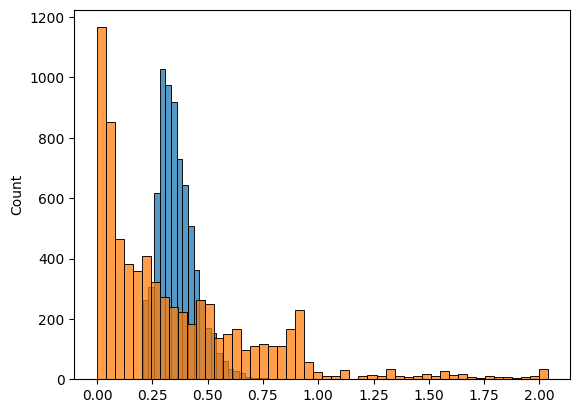

In [144]:
n_bins = 50
sns.histplot(mlp_predictions, bins=50)
sns.histplot(mlp_targets, bins=n_bins)
plt.show()

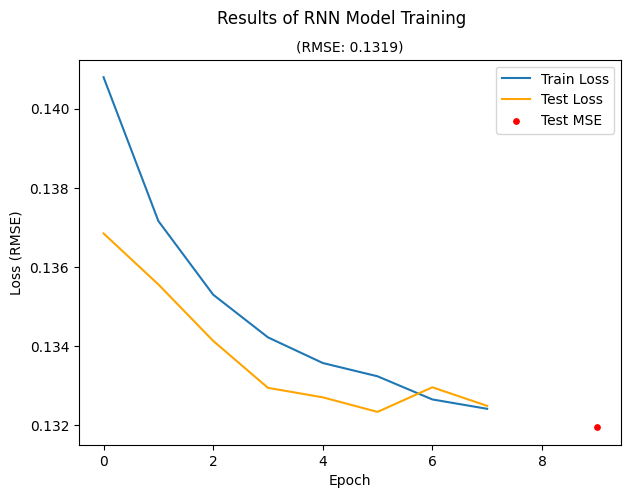

In [145]:
# Plot loss over time, final test stats
plt.figure(figsize=(7, 5))
plt.suptitle("Results of RNN Model Training")
plt.title(f"(RMSE: {rnn_test_MSE:.4})", size=10)
plt.ylabel('Loss (RMSE)')
plt.xlabel('Epoch')
plt.plot(rnn_log[2:], label='Train Loss')
plt.plot(rnn_eval_log[2:], label='Test Loss', color='orange')
plt.scatter(x=epoch-1, y=rnn_test_MSE, color='r', label="Test MSE", s=15)
plt.legend()
plt.show()

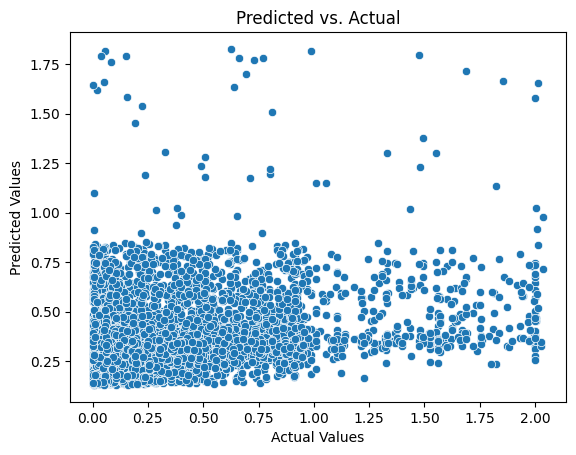

In [120]:
# Plot predicted vs. actual
plt.title("Predicted vs. Actual")
plt.ylabel("Predicted Values")
plt.xlabel("Actual Values")
sns.scatterplot(x=rnn_targets, y=rnn_predictions)
plt.show()

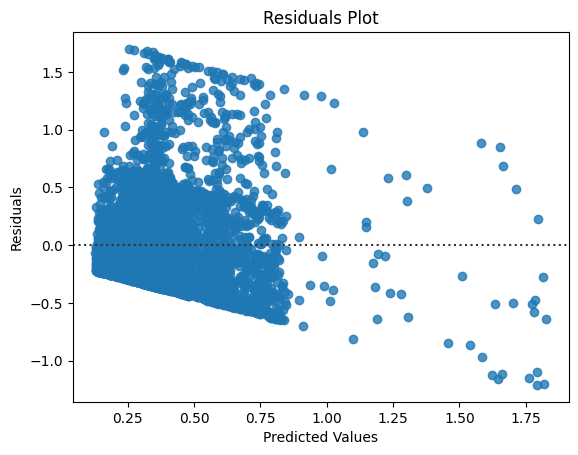

In [121]:
# Plot residuals
plt.title("Residuals Plot")
plt.ylabel("Residuals")
plt.xlabel("Predicted Values")
sns.residplot(x=rnn_predictions, y=rnn_targets, line_kws={"color": "red"})
plt.show()

In [122]:
i = np.random.randint(0, high=5000, size=1, dtype='int').item()
rnn_predictions[i]

np.float32(0.6663593)

## Comparing Two models

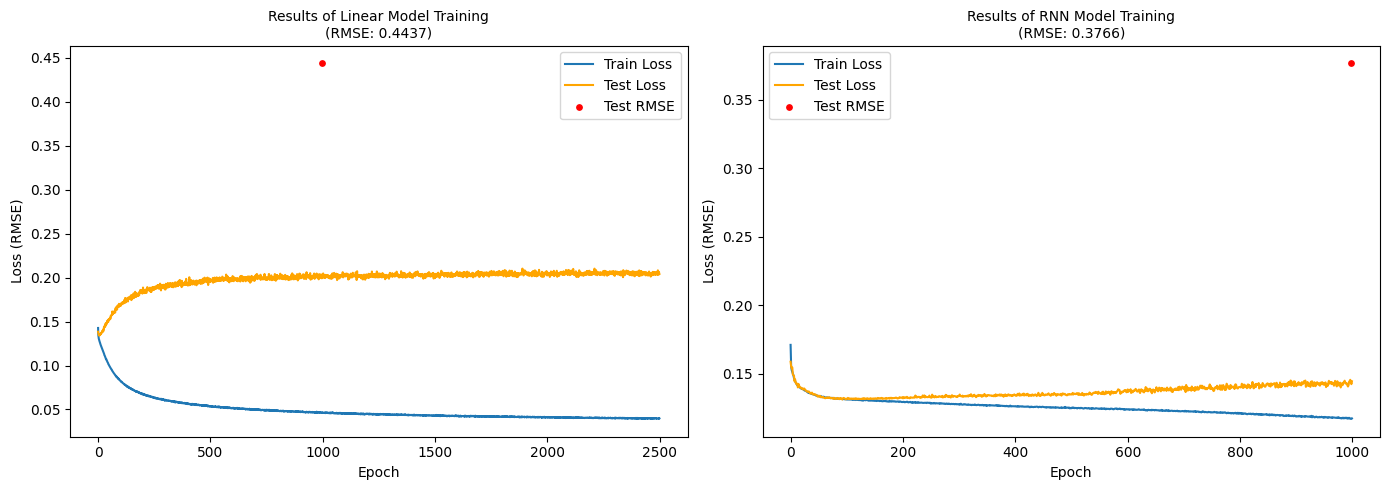

In [123]:
# Create a figure and axis objects for side-by-side plots
fig, ax = plt.subplots(1, 2, figsize=(14, 5))

# Plot for the Linear Model Training
ax[0].set_title(f"Results of Linear Model Training\n(RMSE: {mlp_test_RMSE:.4})", fontsize=10)
ax[0].set_ylabel('Loss (RMSE)')
ax[0].set_xlabel('Epoch')
ax[0].plot(mlp_log, label='Train Loss')
ax[0].plot(mlp_eval_log, label='Test Loss', color='orange')
ax[0].scatter(x=epoch-1, y=mlp_test_RMSE, color='r', label="Test RMSE", s=15)
ax[0].legend()

# Plot for the RNN Model Training
ax[1].set_title(f"Results of RNN Model Training\n(RMSE: {rnn_test_RMSE:.4})", fontsize=10)
ax[1].set_ylabel('Loss (RMSE)')
ax[1].set_xlabel('Epoch')
ax[1].plot(rnn_log, label='Train Loss')
ax[1].plot(rnn_eval_log, label='Test Loss', color='orange')
ax[1].scatter(x=epoch-1, y=rnn_test_RMSE, color='r', label="Test RMSE", s=15)
ax[1].legend()

# Adjust layout and display
plt.tight_layout()
plt.show()
